In [3]:
import pandas as pd
import numpy as np
import time
from pycaret.classification import *

In [4]:
def check_class_ratio(dataset):
    class_ratio = round(np.mean(dataset.CIRC_next_12h), 2)
    return class_ratio

def random_split_stay(df, train_ratio, Threshold, n_trial):
    data = df.copy()
    
    search_time = time.time()
    
    for T in range(n_trial):
        array = data.subject_id.unique()
        
        # seed = np.random.randint(0, 10000, 1)
        seed = 3582
        np.random.seed(seed) 
        np.random.shuffle(array)


        split_point = int(train_ratio * len(array))
        stay_for_train, stay_for_test = np.split(array, [split_point])

        

        condition_train = data.subject_id.isin(stay_for_train)
        holdout_train = data[condition_train]

        condition_test = data.subject_id.isin(stay_for_test)
        holdout_test = data[condition_test]
        
        # holdout_test = holdout_test.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 
        # holdout_train = holdout_train.sort_values(by=['subject_id',  'stay_id', 'Time_since_ICU_admission']) 

        train_class_ratio  = check_class_ratio(holdout_train)
        test_class_ratio  = check_class_ratio(holdout_test)
                
            
        if (train_class_ratio - test_class_ratio) >= Threshold:
            
            break  # 클래스 비율이 모두 threshold 이상일 경우 반복문 종료
        
        if T % 100 == 0:
            print('Trial: ', T)
            
        if T % 10000 == 0:
        
            Threshold = Threshold + 0.05
            print('Threshold 조정 + 0.05, 현재 한계값: {}'.format(Threshold))
        
        if T == 9999:
            print('최대 Trial 달성, 분할 불가')
        
    train = holdout_train.copy()
    test = holdout_test.copy()
    search_time_end = time.time()
    
    trn_class1 = train.CIRC_next_12h.value_counts()[0]
    trn_class2 = train.CIRC_next_12h.value_counts()[1]
    
    tes_class1 = test.CIRC_next_12h.value_counts()[0]
    tes_class2 = test.CIRC_next_12h.value_counts()[1]

    
    
    print('train set : test set = {} : {}'.format(train_ratio, 1-train_ratio))
    print('Train set class: ', train.CIRC_next_12h.value_counts().sort_index())
    print('Test set class: ', test.CIRC_next_12h.value_counts().sort_index())
    print('-'*20)
    print('Train class ratio: {}:{}'.format((trn_class1)/(trn_class1+trn_class2), (trn_class2)/(trn_class1+trn_class2)))
    print('Test class ratio: {}:{}'.format((tes_class1)/(tes_class1+tes_class2), (tes_class2)/(tes_class1+tes_class2)))
    print('-'*20)
    print('Number of trainset patient:', len(train.subject_id.unique()))
    print('Number of testset patient:', len(test.subject_id.unique()))
    print('Number of trainset stay:', len(train.stay_id.unique()))
    print('Number of testset stay:', len(test.stay_id.unique()))
    print('-'*20)
    print('Split seed: ',seed)
    print('train ratio:', train_ratio)
    print('Threshold:', Threshold)
    print('-'*20)
    print('총 소요 시간(초):{}'.format(search_time_end - search_time))
    print('시도한 trial 수: ', T)
    
    return train, test, stay_for_train, stay_for_test

In [5]:
dataset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Case Labeling/mimic_df.csv.gz', index_col = 0, compression='gzip')

In [4]:
# dataset.replace([np.inf, -np.inf], np.nan, inplace=True)

# dataset['pao2/fio2_fillna']=0
# idx = dataset[dataset['pao2/fio2'].isnull()].index
# dataset['pao2/fio2'].loc[idx]=0
# dataset['pao2/fio2_fillna'].loc[idx]=1

In [6]:
def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 2, 3])]
    class_3_subset = filtered_df[(filtered_df['classes'] == 2)|(filtered_df['classes'] == 3)].sample(frac=0.1) 

    class_0_1_df = filtered_df[filtered_df['classes'].isin([0, 1])]
    result_df = pd.concat([class_0_1_df, class_3_subset])

    return result_df

In [7]:
mimic_train_ori, mimic_valid_ori, trn_patient, val_patient = random_split_stay(dataset, 0.7, Threshold=0.05, n_trial=1) 
mimic_train_ori_sampling = filter_classes_with_condition(mimic_train_ori)

Trial:  0
Threshold 조정 + 0.05, 현재 한계값: 0.1
train set : test set = 0.7 : 0.30000000000000004
Train set class:  0.0    1185365
1.0     228480
Name: CIRC_next_12h, dtype: int64
Test set class:  0.0    524016
1.0    102182
Name: CIRC_next_12h, dtype: int64
--------------------
Train class ratio: 0.8383981270931397:0.16160187290686037
Test class ratio: 0.8368215803946994:0.16317841960530055
--------------------
Number of trainset patient: 12918
Number of testset patient: 5537
Number of trainset stay: 14337
Number of testset stay: 6212
--------------------
Split seed:  3582
train ratio: 0.7
Threshold: 0.1
--------------------
총 소요 시간(초):1.364832878112793
시도한 trial 수:  0


In [7]:
mimic_train_ori_sampling.classes.value_counts()

0    1175656
1      22253
3      20943
2        651
Name: classes, dtype: int64

In [8]:
# original space, circulatory prediction

input_space_clf_setting = setup(data = mimic_train_ori_sampling.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1), target = 'CIRC_next_12h',
                                test_data = mimic_valid_ori.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1),
                                index=False, session_id = 123)

,Description,Value
0,Session id,123
1,Target,CIRC_next_12h
2,Target type,Binary
3,Original data shape,"(1845701, 215)"
4,Transformed data shape,"(1845701, 215)"
5,Transformed train set shape,"(1219503, 215)"
6,Transformed test set shape,"(626198, 215)"
7,Numeric features,214
8,Preprocess,True
9,Imputation type,simple


In [9]:
test_data = mimic_valid_ori.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1)

In [10]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import numpy as np
from tqdm import tqdm

def filter_numeric_elements(lst):
    return [x for x in lst if isinstance(x, (int, float))]

def calculate_cap_recall(df, stid):
    # 데이터프레임 복사본 생성
    df_stid = df[df['stay_id'] == stid].copy()

    # 연속적인 circ 이벤트 처리
    df_stid['circ_event'] = (df_stid['Annotation'] == 'circ') & (df_stid['Annotation'].shift(1) != 'circ')

    # circ 이벤트 시작 시점 찾기
    circ_start_times = df_stid[df_stid['circ_event']]['Time_since_ICU_admission'].tolist()
    captured_events = 0
    drop_event = 0
    for start_time in circ_start_times:
        if start_time == df_stid['Time_since_ICU_admission'].values[0]:
            drop_event += 1
        else:
            window_start = start_time - 12
            previous_times = df_stid[(df_stid['Time_since_ICU_admission'] >= window_start) & (df_stid['Time_since_ICU_admission'] < start_time)]

            # 이전 시간 데이터가 없는 경우도 평가에서 제외
            if previous_times.empty:
                drop_event += 1
            elif any(previous_times['prediction_label'] == 1):
                captured_events += 1

    total_events = len(circ_start_times) - drop_event
    if total_events > 0:
        return captured_events / total_events
    else:
        return f'no event in stay id {stid}'  # 또는 적절한 값 반환
    
    
def calculate_precision(df, stid):
    # 특정 stay_id에 대한 데이터만 필터링
    df_stid = df[df['stay_id'] == stid].copy()

    df_stid['circ_event'] = (df_stid['Annotation'] == 'circ') & (df_stid['Annotation'].shift(1) != 'circ')
    circ_start_times = df_stid[df_stid['circ_event']]['Time_since_ICU_admission'].tolist()
    
    # True Alarms와 Total Alarms 초기화
    true_alarms = 0
    total_alarms = 0
    
    # 데이터 프레임의 첫 관측치 시간 가져오기
    first_observation_time = df_stid['Time_since_ICU_admission'].min()
    
    for start_time in circ_start_times:
        # 첫 관측치에서 circ가 시작된 경우, 이를 precision 계산에서 제외
        if start_time == first_observation_time:
            continue
        
        # 이벤트 발생 전 12시간 동안의 예측된 알람 찾기
        window_start = max(start_time - 12, first_observation_time)  # window 시작이 첫 관측치 시간보다 이전이면 첫 관측치 시간으로 설정
        window_end = start_time
        alarms_in_window = df_stid[(df_stid['Time_since_ICU_admission'] >= window_start) & 
                                   (df_stid['Time_since_ICU_admission'] < window_end) & 
                                   (df_stid['prediction_label'] == 1)]
        
        # 전체 알람 (Total Alarms) 계산
        total_alarms += len(alarms_in_window)

        # 진정한 알람 (True Alarms) 계산
        if df_stid.loc[df_stid['Time_since_ICU_admission'] == start_time, 'CIRC_next_12h'].any():
            true_alarms += len(alarms_in_window)

    # Precision 계산
    precision = true_alarms / total_alarms if total_alarms > 0 else 0  # 알람이 전혀 없으면 precision은 0으로 설정
    
    return precision


def make_evaluation(model):
    global evaluation
    pred_df = predict_model(model, raw_score=True)

    evaluation = mimic_valid_ori[['subject_id', 'stay_id', 'Time_since_ICU_admission', 'Annotation','classes', 'CIRC_next_12h']].copy()
    evaluation['prediction_label'] = pred_df['prediction_label'].values

    case2_recall_precision = evaluation[(evaluation['classes']==0) | (evaluation['classes']==1)]

    case_2precision = precision_score(case2_recall_precision['CIRC_next_12h'], case2_recall_precision['prediction_label'])
    case_2recall = recall_score(case2_recall_precision['CIRC_next_12h'], case2_recall_precision['prediction_label'])
    

    recall = []
    for stid in evaluation.stay_id.unique():
        recall.append(calculate_cap_recall(evaluation, stid))

    filtered_list = filter_numeric_elements(recall)
    total_recall = np.nanmean(filtered_list)

    precisions = []
    for stid in evaluation['stay_id'].unique():
        precisions.append(calculate_precision(evaluation, stid))

    non_string_indices = [index for index, item in enumerate(recall) if not isinstance(item, str)]
    precisions = [precisions[index] for index in non_string_indices]

    mean_precision = np.mean([p for p in precisions if isinstance(p, (int, float))])

    d = {'Model': [f'{model}'], 'Event Recall': [total_recall], 'Event Precision': [mean_precision], 'Case 2 Recall': [case_2recall], 'Case 2 Precision': [case_2precision]}
    performance = pd.DataFrame(d)
    display(performance)

In [12]:
nb = create_model('nb', cross_validation=False)
make_evaluation(nb)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9444,0.9590,0.8411,0.8221,0.8315,0.7982,0.7982


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.9444,0.9590,0.8411,0.8221,0.8315,0.7982,0.7982


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"GaussianNB(priors=None, var_smoothing=1e-09)",0.56221,0.552947,0.215559,0.116536


In [21]:
def IoC(precision, recall, beta):
    score = (1+beta**2)*precision*recall/((beta**2)*precision+recall)
    return score

nbioc = IoC(precision=0.552947, recall=0.56221, beta= 2)
nbioc_1 = IoC(precision=0.552947, recall=0.56221, beta= 1.5)

In [23]:
nbioc_1

0.5593269607783027

In [22]:
nbioc

0.5603326550163339

In [14]:
lightgbm = create_model('lightgbm', cross_validation=False, learning_rate=0.1)
make_evaluation(lightgbm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9797,0.9900,0.9215,0.9523,0.9366,0.9245,0.9247


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9797,0.9900,0.9215,0.9523,0.9366,0.9245,0.9247


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"LGBMClassifier(boosting_type='gbdt', class_wei...",0.600219,0.5911,0.274898,0.475641


In [25]:
lightgbmioc = IoC(precision=0.5892, recall=0.5975, beta= 2)
print(lightgbmioc)
lightgbmioc = IoC(precision=0.5892, recall=0.5975, beta= 1.5)
print(lightgbmioc)

0.5958213451579054
0.5949213550332778


In [ ]:
0.605872	0.59607	0.282198	0.444116

In [10]:
xgboost = create_model('xgboost', cross_validation=False, learning_rate=0.1)
make_evaluation(xgboost)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9825,0.9918,0.9213,0.9697,0.9449,0.9345,0.9349


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9825,0.9918,0.9213,0.9697,0.9449,0.9345,0.9349


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"XGBClassifier(base_score=None, booster='gbtree...",0.606696,0.597701,0.273543,0.678479


In [24]:
xgboostioc = IoC(precision=0.597701, recall=0.606696, beta= 2)
print(xgboostioc)
xgboostioc = IoC(precision=0.597701, recall=0.606696, beta= 1.5)
print(xgboostioc)

0.604875405998332
0.6038996046611282


In [ ]:
0.60284	0.593119	0.273543	0.679358

In [11]:
lr = create_model('lr', cross_validation=False)
make_evaluation(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9728,0.9851,0.8690,0.9603,0.9124,0.8963,0.8979


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9728,0.9851,0.8690,0.9603,0.9124,0.8963,0.8979


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.467538,0.465051,0.171342,0.673361


In [26]:
l2r = IoC(precision=0.465051, recall=0.467538, beta= 2)
print(l2r)
l2r = IoC(precision=0.465051, recall=0.467538, beta= 1.5)
print(l2r)

0.46703847427678846
0.46676994075312966


In [ ]:
0.355126	0.353215	0.163729	0.569873

In [12]:
svm = create_model('svm', cross_validation=False)
make_evaluation(svm)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.9729,0.9301,0.8666,0.9640,0.9127,0.8967,0.8985


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.9729,0.9301,0.8666,0.9640,0.9127,0.8967,0.8985


,Model,Event Recall,Event Precision,Case 2 Recall,Case 2 Precision
0,"SGDClassifier(alpha=0.0001, average=False, cla...",0.336053,0.338537,0.076025,0.730461


In [ ]:
0.521567	0.512582	0.245698	0.520778

In [27]:
l2r = IoC(precision=0.512582, recall=0.521567, beta= 2)
print(l2r)
l2r = IoC(precision=0.512582, recall=0.521567, beta= 1.5)
print(l2r)

0.5197448884849498
0.5187690148978149


In [6]:
rbfsvm = create_model('rbfsvm', cross_validation=False)
make_evaluation(rbfsvm)

ValueError: _CURRENT_EXPERIMENT global variable is not set. Please run setup() first.

In [6]:
mimic_train_ori_sampling.CIRC_next_12h.value_counts()

0.0    1176602
1.0      42901
Name: CIRC_next_12h, dtype: int64

In [7]:
# 클래스 레이블을 기준으로 데이터를 분리
class_0 = mimic_train_ori_sampling[mimic_train_ori_sampling['CIRC_next_12h'] == 0]
class_1 = mimic_train_ori_sampling[mimic_train_ori_sampling['CIRC_next_12h'] == 1]

# 클래스의 수를 맞추기 위해 더 적은 수의 클래스 수에 맞춰서 샘플링
# 여기서는 클래스 1의 개수에 맞춤
class_0_under = class_0.sample(len(class_1))

# 언더샘플링된 데이터셋을 클래스 1과 합침
df_balanced = pd.concat([class_0_under, class_1])

In [8]:
#RBF svm

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV


scaler = StandardScaler()


train_x = df_balanced.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1).copy()
train_y = df_balanced['CIRC_next_12h'].values

test_x = mimic_valid_ori.drop(['Unnamed: 0', 'subject_id', 'stay_id', 'hadm_id','Annotation','classes'], axis = 1).copy()
test_y = mimic_valid_ori['CIRC_next_12h'].values

train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

from sklearn.svm import SVC

# define the parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'gamma':[0.0001, 0.001, 0.01, 1, 10, 100, 1000]}
 
# perform grid search
svm = SVC(kernel='rbf', gamma=100, C=10, random_state=100)
svm.fit(train_x_scaled, train_y)
Y_pred = svm.predict(test_x)

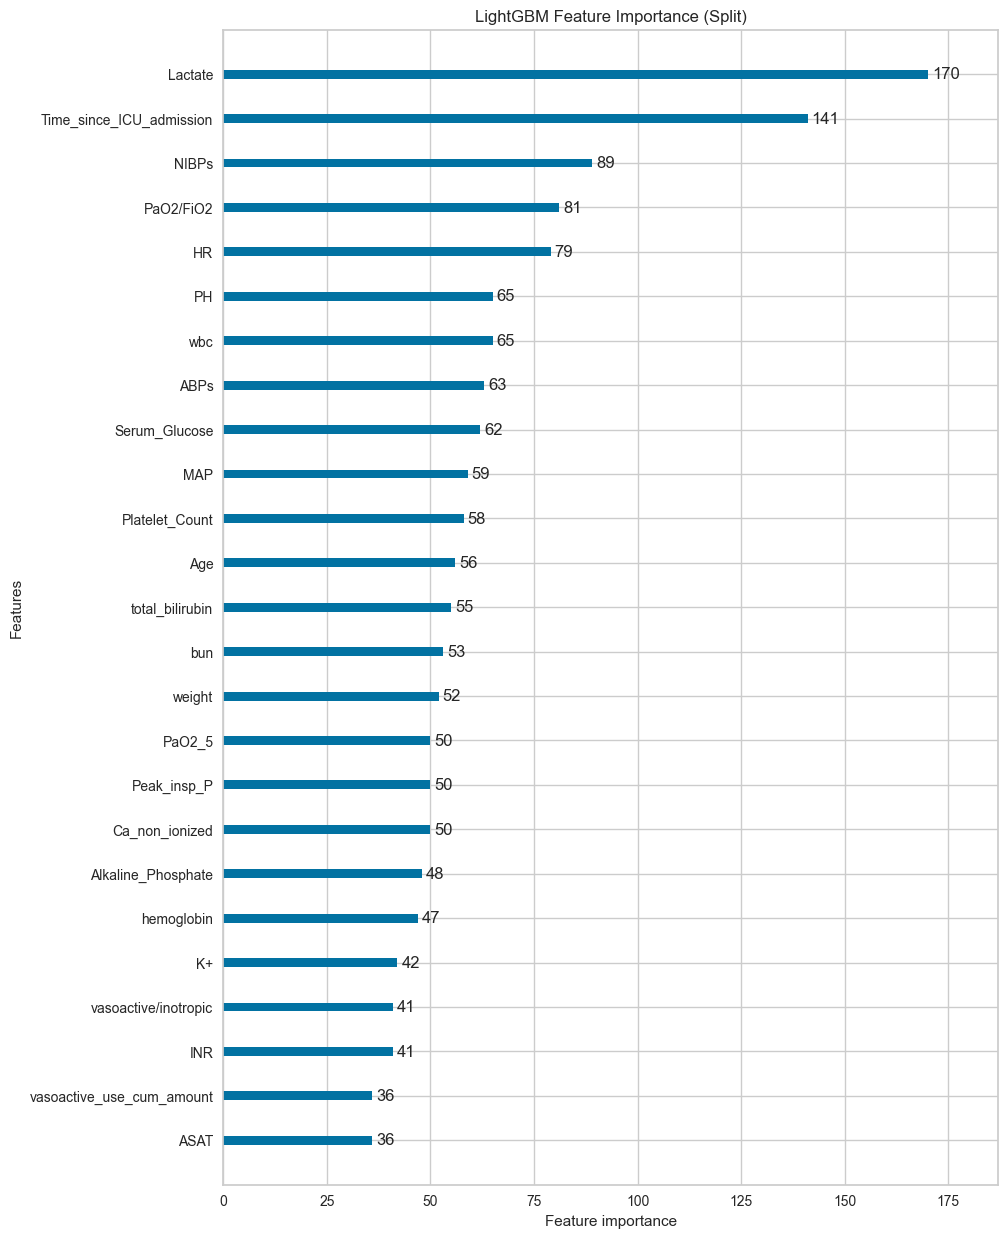

In [27]:
import matplotlib.pyplot as plt
import lightgbm as lgb
lgb.plot_importance(lightgbm, importance_type="split", figsize=(10,15), title="LightGBM Feature Importance (Split)", max_num_features=25)
plt.show()

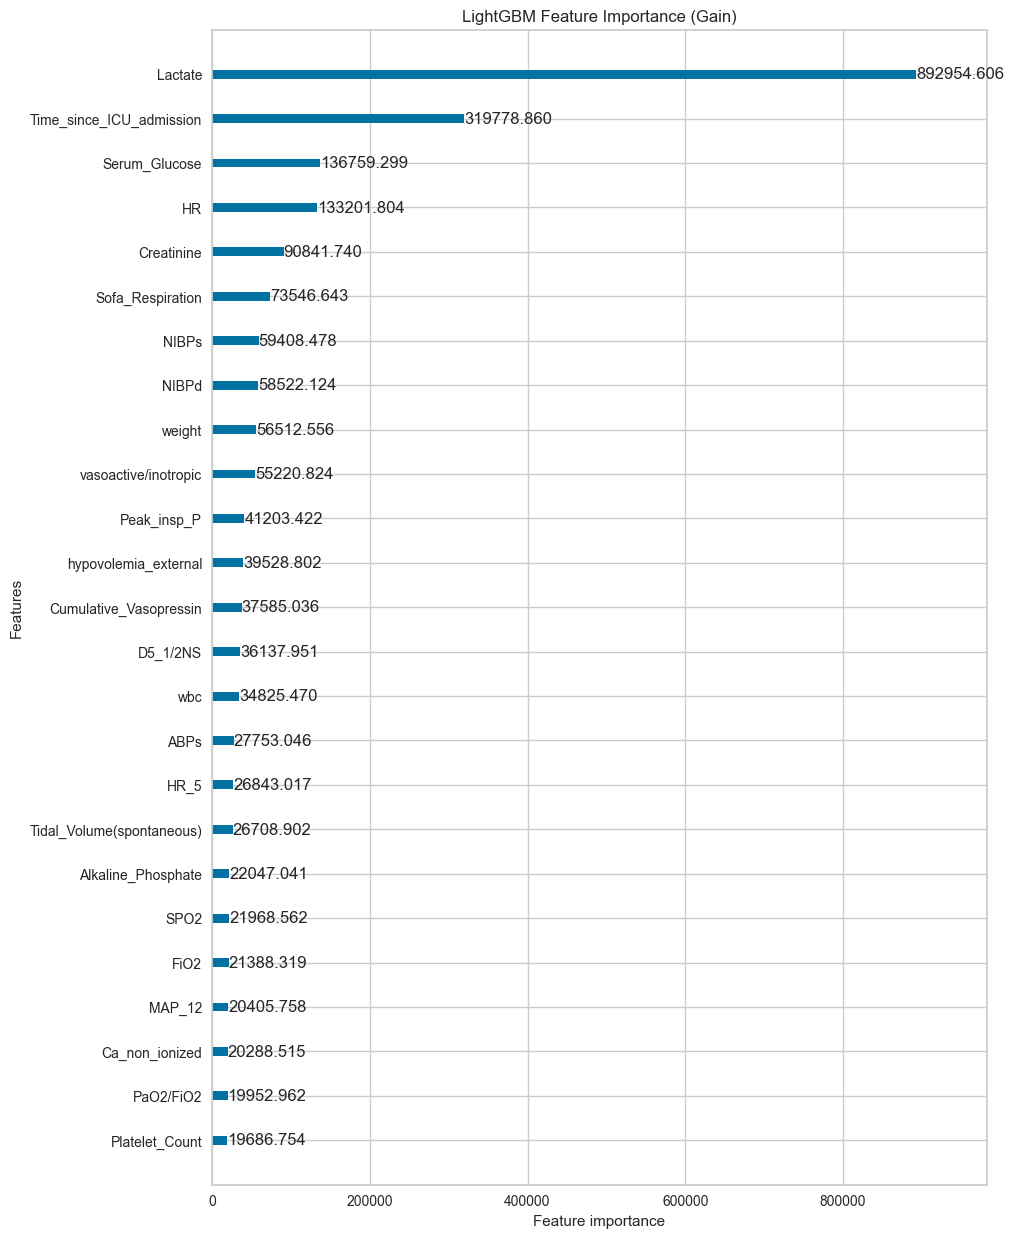

In [28]:
import matplotlib.pyplot as plt
import lightgbm as lgb
lgb.plot_importance(lightgbm, importance_type="gain", figsize=(10,15), title="LightGBM Feature Importance (Gain)", max_num_features=25)
plt.show()

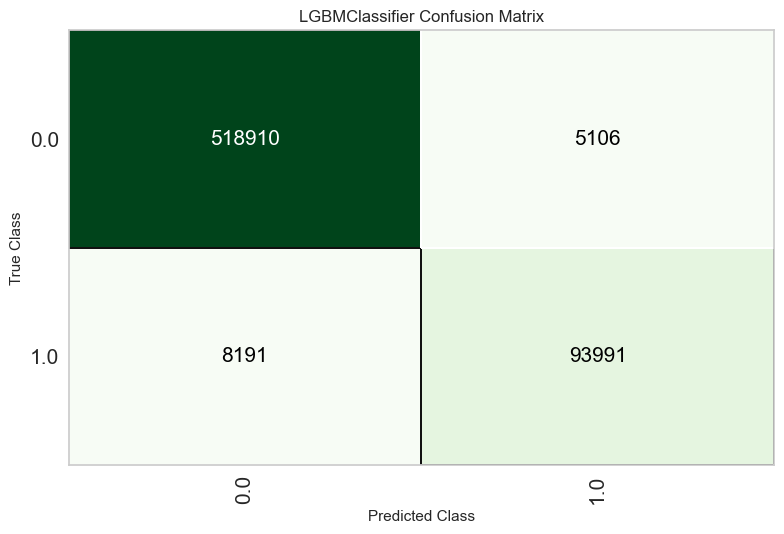

In [65]:
plot_model(lightgbm, plot='confusion_matrix')